Hail Tutorial
==========

This notebook, based on a workshop given in February 2019 by the Hail Team with additional supplementary information from the [hail.is website](https://hail.is/docs/0.2/tutorials-landing.html) will introduce the following concepts:

 - Loading genetic data into Hail
 - General-purpose data exploration functionality
 - Annotation and Quality control of sequencing data
 - Running a Genome-Wide Association Study (GWAS)
 - Rare variant burden tests
 - Rare variant analysis
 - Other examples of Hail programs

**Tutorial Disclaimer**

This workspace is an introductory tutorial only. It demonstrates the basics of using the Hail package, but does not currently support Hail’s high-performance features. It should not be used to attempt to run Hail at large scale. For high-performance applications, please see the Hail package documentation [here](https://hail.is).

This workspace was last run in April, 2019 using Hail 2.10

<span style="font-size:2em;strong">Matrix Table Structure in Hail</span>

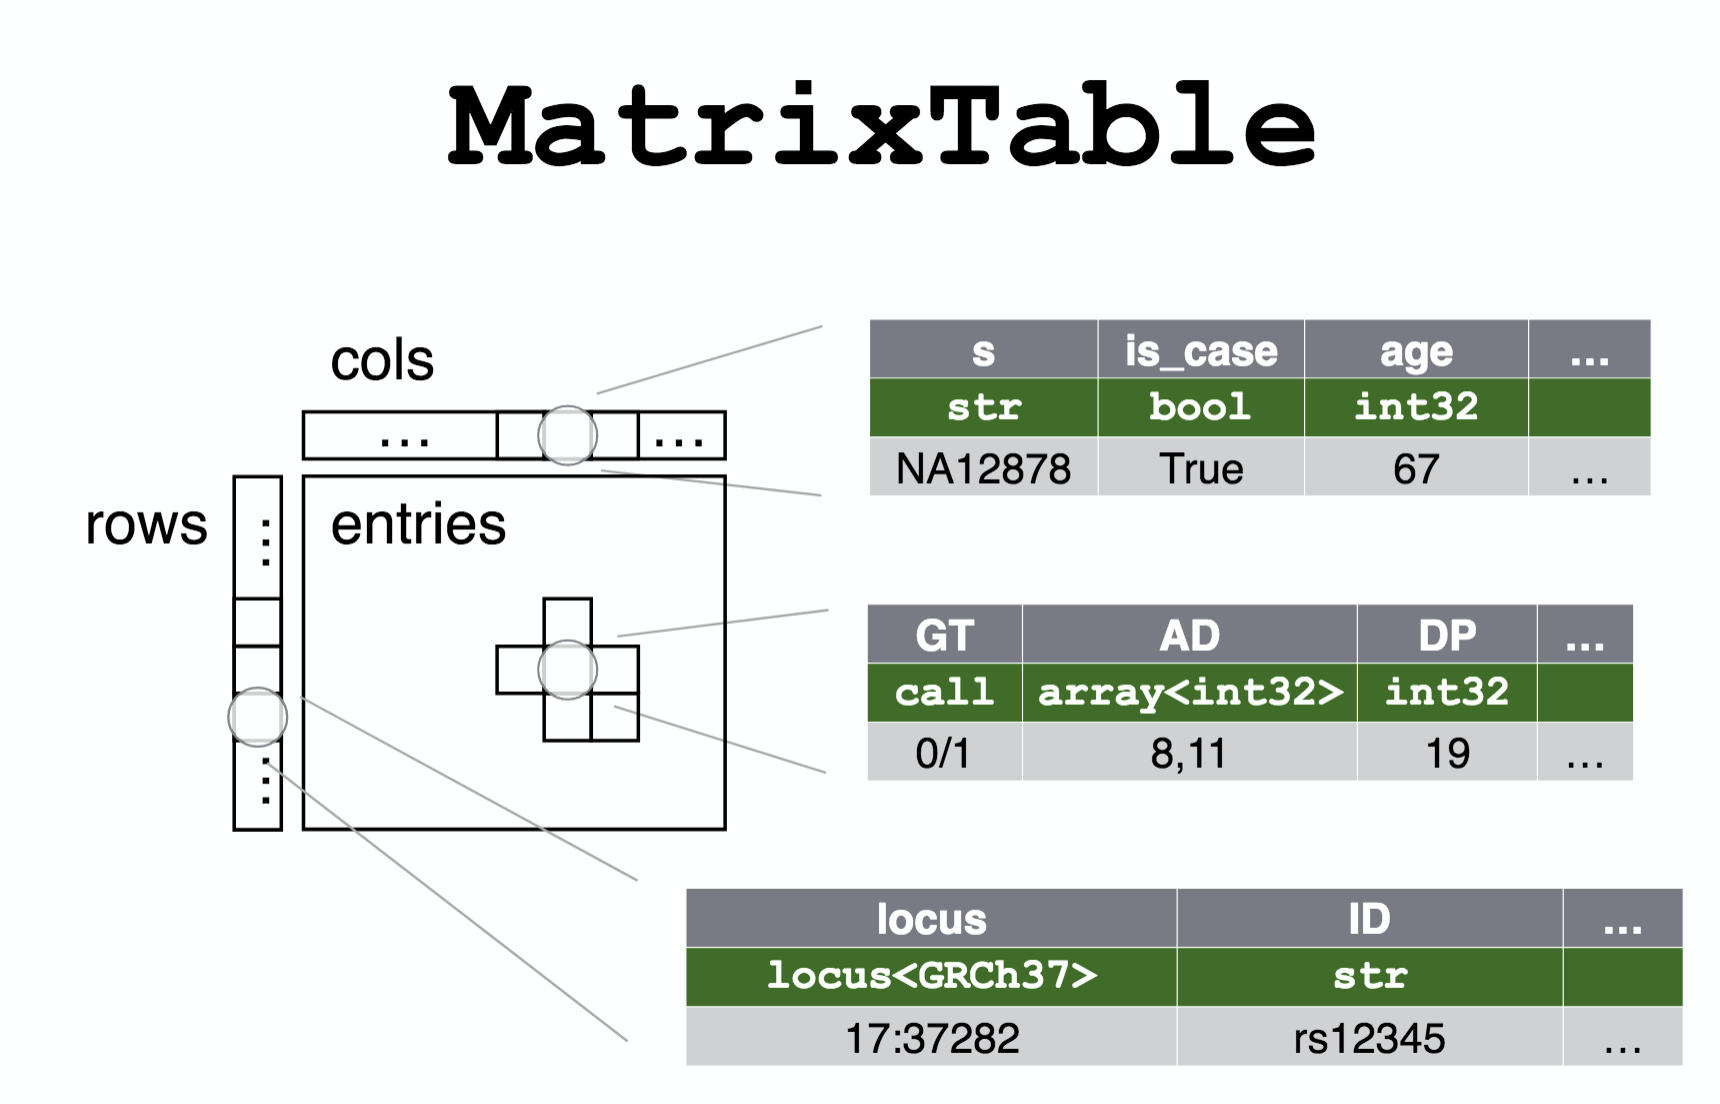

A typical workflow in Hail begins with importing genotype data from a standard file format such as VCF, PLINK Binary files, GEN, or BGEN files into Hail’s Matrix Table format. Next, samples and variants are annotated with additional meta-information such as phenotype for samples and functional consequence for variants. Samples, variants, and genotypes are filtered from the dataset based on expressions constructed using Hail’s Domain-Specific Language. Once the dataset has been cleaned, various analytic methods such as PCA and logistic regression are used to find genetic associations. Lastly, data is exported to a variety of file formats.



Hail represents a genetic data set as a matrix similar to VCF files where the rows are keyed by variant objects, the columns are keyed by samples, and each cell is a genotype object. 


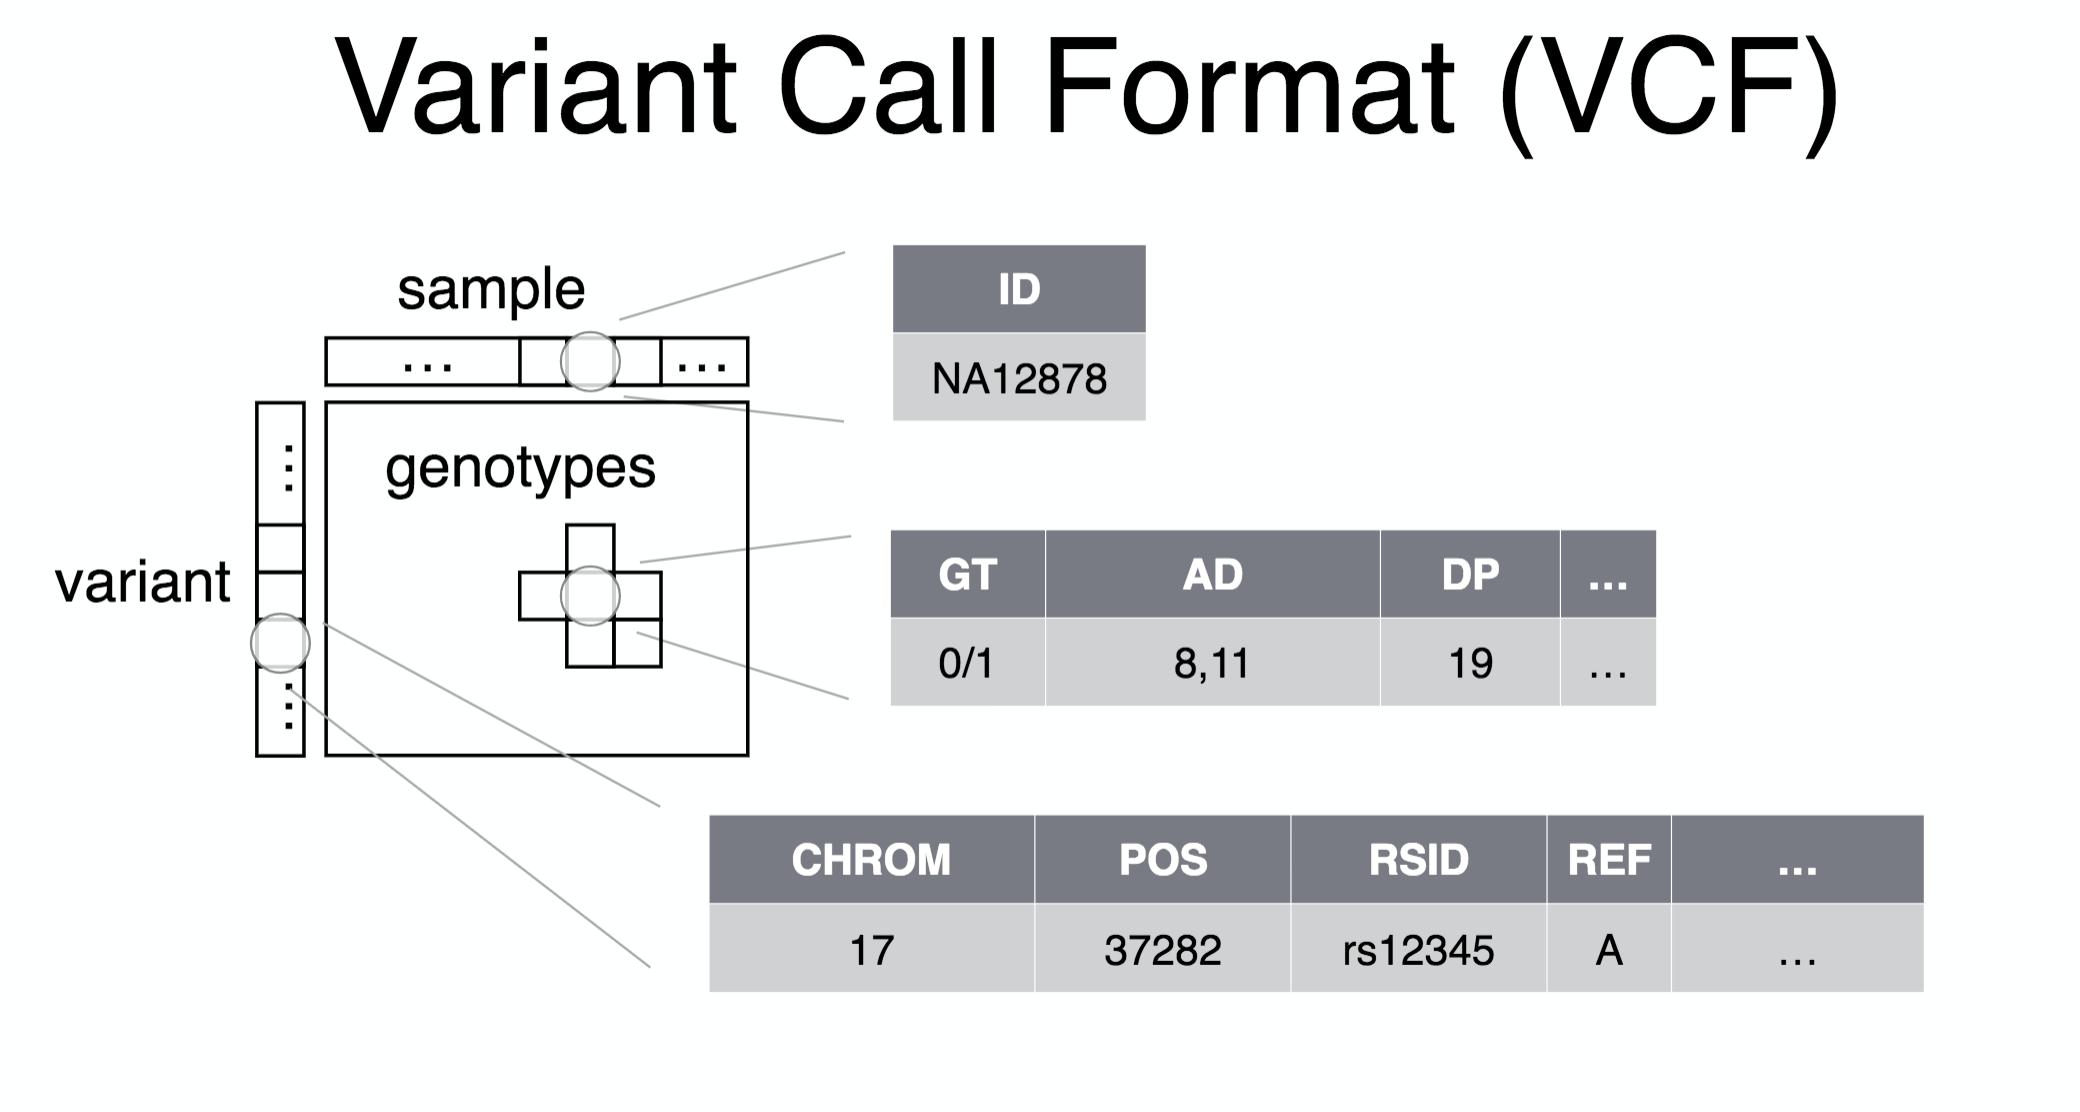


Variant objects and Genotype objects each have methods to access attributes such as chromosome name and genotype call. Although this representation is similar to the VCF format, Hail uses a fast and storage-efficient internal representation called a Matrix Table.



# Hail in a Jupyter Notebook

**Hail** is an open-source, scalable framework for exploring and analyzing genomic data. (from https://hail.is/)

**Jupyter Notebook** - an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and narrative text. Uses include: data cleaning and transformation, numerical simulation, statistical modeling, data visualization, machine learning, and much more. (from https://jupyter.org)

In the last year, the Jupyter development team [released Jupyter Lab](https://blog.jupyter.org/jupyterlab-is-ready-for-users-5a6f039b8906), an integrated environment for data, code, and visualizations. If you've used R Studio, this is the closest thing that works in Python. Notebooks support many other languages, too!

### Why notebooks?

Part of what we think is so exciting about Hail is that it has coincided with a larger shift in the data science community.

Three years ago, most computational biologists at Broad analyzed genetic data using command-line tools, and took advantage of research compute clusters by explicitly using scheduling frameworks like LSF or Sun Grid Engine.

Now, they have the option to use Hail in interactive Python notebooks backed by thousands of cores on public compute clouds like [Google Cloud](https://cloud.google.com/), [Amazon Web Services](https://aws.amazon.com/), or [Microsoft Azure](https://azure.microsoft.com/).

AN INTRODUCTORY TUTORIAL ON HOW TO USE JUPYTER NOTEBOOKS IN TERRA CAN BE FOUND IN THIS WORKSPACE.

If, for some reason this notebook has become detached from the intro lesson, it can be found [here.](https://storage.googleapis.com/terra-featured-workspaces/hail-tutorials/Intro_to_Jupyter_Notebooks/Intro_to_Jupyter_Notebooks.ipynb)

## Set up a Python environment to run Hail in Terra

Install Hail on your VM. The exclamation point in front of the command indicates that this is a bash command.  

In [ ]:
#!pip install hail --upgrade 
#The command above is only needed when not in Terra, hail is automatically loaded when the cluster is created.
from firecloud import fiss
import hail as hl
import os


## Linking Jupyter Notebook to workspace and data

This Jupyter notebook is running in a Docker container in a VM created by Terra, we need to add a step that is not necdessary when running Hail on your local machine.  We need to tell the notebook where our Terra workspace is so that our files will be generated inside the Terra workspace.

The notebook cluster is by default a small machine.  Files should be written in and out of the google bucket to prevent errors. 

In [ ]:
#Set the billing project ID
BILLING_PROJECT_ID = os.environ['GOOGLE_PROJECT']
BILLING_PROJECT_ID 

In [ ]:
#Set the workspace name to the current workspace
WORKSPACE = "example_hail_notebook"
WORKSPACE

In [ ]:
# get the right bucket to write out to
bucket = 'gs://'+fiss.fapi.get_workspace(BILLING_PROJECT_ID, WORKSPACE).json()['workspace']['bucketName']

Now, instead of having to write out the long name for our workspace google bucket, we can just refer to the variable "bucket".

In [ ]:
print(bucket)

Check to see if you have found your workspace by using a simple bash command `gsutil ls` (preceded by `!`) to list the directory.  Any bash command can be run as if in the terminal by placing the `!` before it.  We have to use the `gsutil` version of commands because we are talking to a bucket on the google cloud, automatically generated by Terra when you start a new workspace.  More gsutil commands can be [found here](https://cloud.google.com/storage/docs/gsutil/commands/help).

In [ ]:
#This should be empty if the data has note been imported into this cluster before
!gsutil ls $bucket/data

## Import Bokeh plotting library

In addition to Hail, we import a few methods from the [bokeh](https://bokeh.pydata.org/en/latest/) plotting library. We'll see examples soon!

In [ ]:
#!pip install bokeh
#The command above is only needed when not in Terra, bokeh is automatically loaded when the cluster is created.

from bokeh.resources import INLINE
import bokeh.io
from bokeh import *
bokeh.io.output_notebook(INLINE)

Run this code block to test that the bokeh plotting tool is working correctly.

In [ ]:
from bokeh.plotting import figure, output_file, show

plot = figure(plot_width=300, plot_height=300)
plot.annulus(x=[1, 2, 3], y=[1, 2, 3], color="#7FC97F",
             inner_radius=0.2, outer_radius=0.5)

show(plot)

In [ ]:
#Initialize Hail
hl.init()

If you see an error with the last line similar to this:

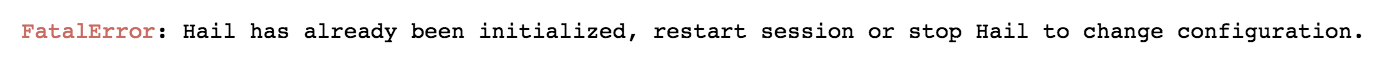

Don't worry, it just means that this cell has been run successfully and does not need to be rerun.

## Download public 1000 Genomes data

The workshop materials are designed to work on a small (~20MB) downsampled chunk of the public 1000 Genomes dataset.

You can run these same functions on your computer or on the cloud!

In [ ]:
hl.utils.get_1kg(bucket + '/data')

In [ ]:
!gsutil ls $bucket/data

# Explore genetic data with Hail

## Read 1KG into Hail

Like tables, matrix tables can be imported from a variety of formats: VCF, (B)GEN, PLINK, TSV, etc. Matrix tables can also be read from a “native” matrix table format. Let’s read a sample of prepared 1KG data.

We represent genetic data as a Hail [MatrixTable](https://hail.is/docs/0.2/overview/matrix_table.html), and name our variable `mt` to indicate this.

In [ ]:
mt = hl.read_matrix_table(bucket+'/data/1kg.mt')

This next command just makes sure that the data has been loaded into the workspace correctly.  You should see output that looks like this:



!<img src = attachment:image.png width="600">(attachment:image.png)
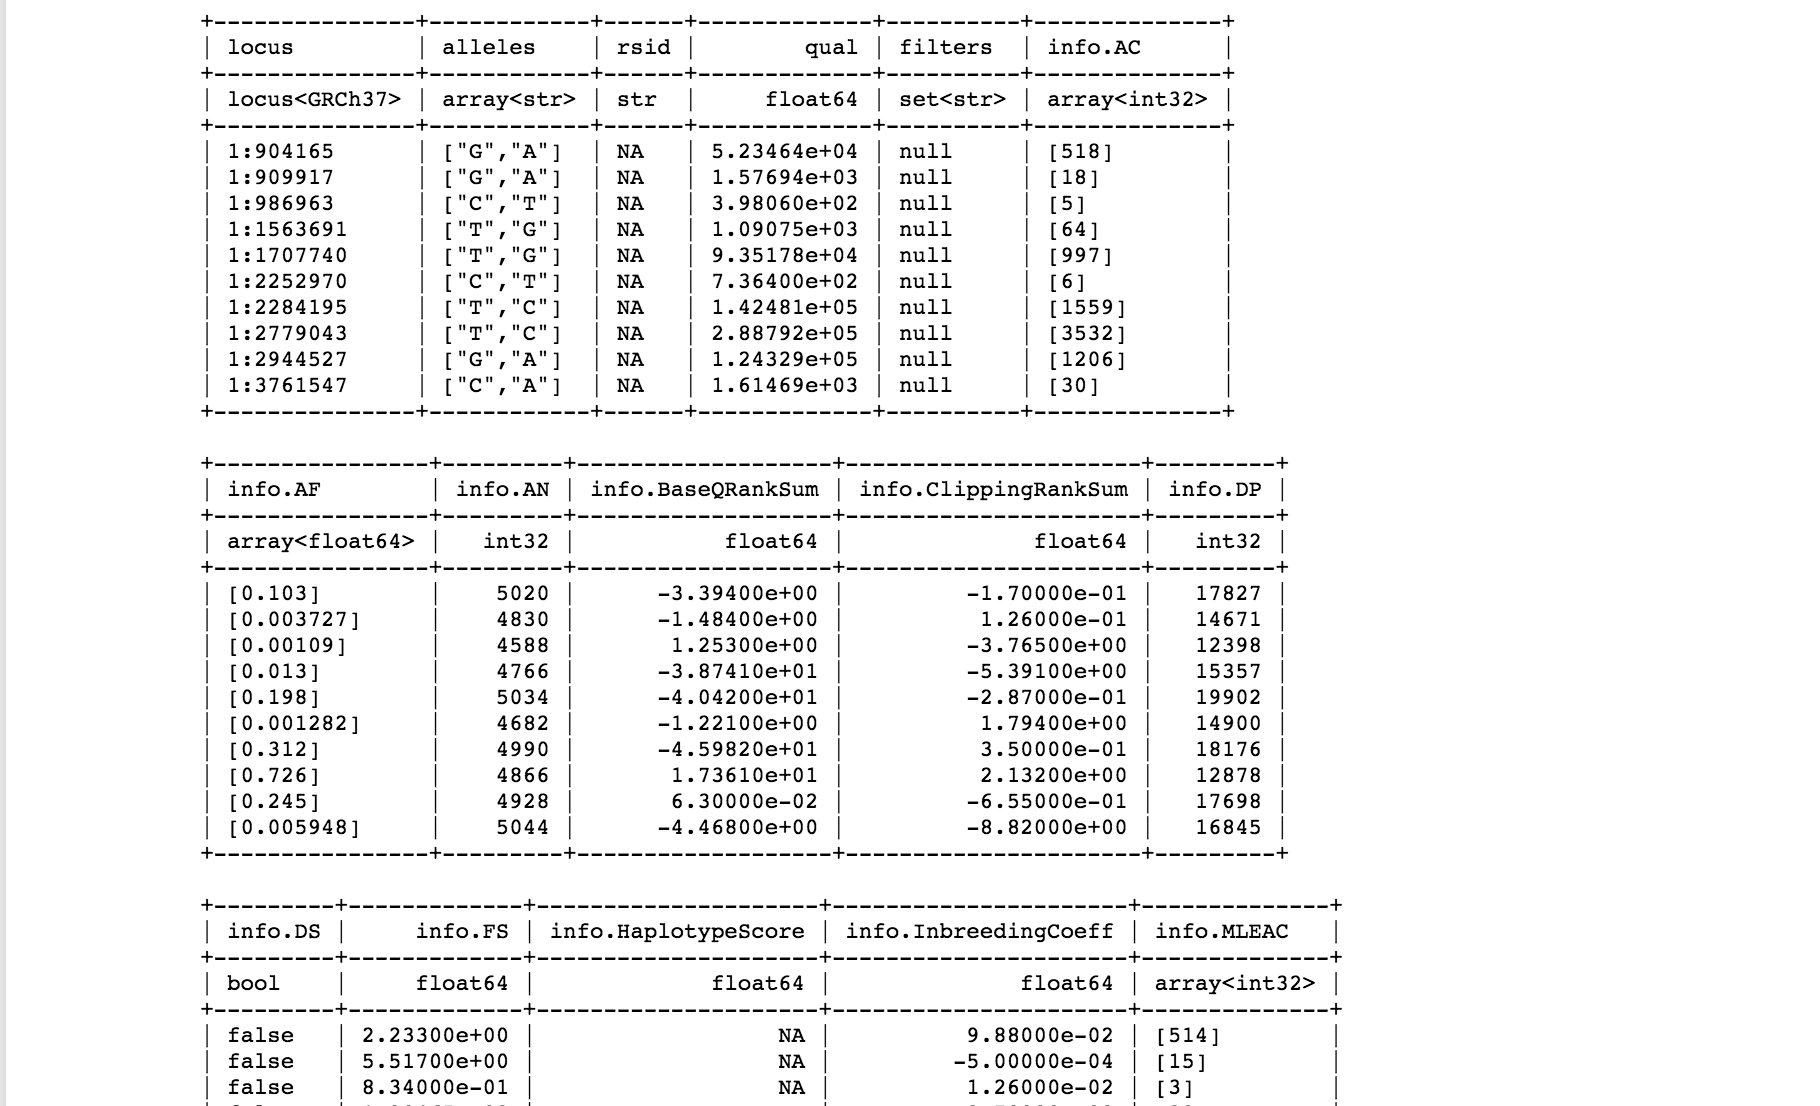

In [ ]:
mt.rows().show()

## What is a `MatrixTable`?

Let's describe it!

The `describe` method prints the **schema**, that is, the fields in the dataset and their types.

You can see:
 - **numeric** types:
     - integers (`int32`, `int64`), e.g. `5`
     - floating point numbers (`float32`, `float64`), e.g. `5.5` or `3e-8`
 - **strings** (`str`), e.g. `"Foo"`
 - **boolean** values  (`bool`) e.g. `True`
 - **collections**:
     - arrays (`array`), e.g. `[1,1,2,3]`
     - sets (`set`), e.g. `{1,3}`
     - dictionaries (`dict`), e.g. `{'Foo': 5, 'Bar': 10}`
 - **genetic data types**:
     - loci (`locus`), e.g. `[GRCh37] 1:10000` or `[GRCh38] chr1:10024`
     - genotype calls (`call`), e.g. `0/2` or `1|0`

A good way to peek at the structure of a `Table` is to look at its `schema`.  We use a Hail tool called `describe` to show the structure of the underlying table.

In [ ]:
mt.describe()

`Table` is Hail’s distributed analogue of a data frame or SQL table. It will be familiar if you’ve used R or `pandas`, but `Table` differs in 3 important ways:

1.  It is distributed. Hail tables can store far more data than can fit on a single computer.
2.  It carries global fields.
3.  It is keyed.

A `Table` has two kinds of fields:

* global fields
* row fields

A `MatrixTable` has four kinds of fields:

* global fields
* row fields
* column fields
* entry fields


Row fields are fields that are stored once per row. These can contain information about the rows, or summary data calculated per row.

Column fields are stored once per column. These can contain information about the columns, or summary data calculated per column.

Entry fields are the piece that makes this structure a matrix – there is an entry for each (row, column) pair.

If you’ve gotten this far, you’re probably thinking:

“Can’t I do all of this in pandas or R?”

“What does this have to do with biology?”

The two crucial features that Hail adds are *scalability* and the *domain-specific primitives* needed to work easily with biological data. Fear not! You’ve learned most of the basic concepts of Hail and now are ready for the bit that makes it possible to represent and compute on genetic matrices: the [MatrixTable](https://hail.is/docs/0.2/hail.MatrixTable.html).

## Getting to know our data

It’s important to have easy ways to slice, dice, query, and summarize a dataset. Some of this functionality is demonstrated below.

### rows

The [rows](https://hail.is/docs/0.2/hail.MatrixTable.html#hail.MatrixTable.rows) method can be used to get a table with all the row fields in our MatrixTable.

We can use `rows` along with [select](https://hail.is/docs/0.2/hail.Table.html#hail.Table.select) to pull out 5 variants. 

The `select` method takes either a string refering to a field name in the table, or a Hail [Expression](https://hail.is/docs/0.2/expr/expression.html#hail.expr.expression.Expression). Here, we leave the arguments blank to keep only the row key fields, `locus` and `alleles`.

Use the show method to display the variants.



In [ ]:
mt.rows().select().show(5)

Another method to do the same thing:

In [ ]:
mt.row_key.show(5)

### show
There is no mt.show() method, but you can show individual fields like the sample ID (s), or the locus (locus).

Here is how to peek at the first few sample IDs and the first few loci.

In [ ]:
mt.s.show(5)

In [ ]:
mt.locus.show(5)

### take

To look at the first few genotype calls, we can use [entries](https://hail.is/docs/0.2/hail.MatrixTable.html#hail.MatrixTable.entries) along with `select` and `take`. The take method collects the first n rows into a list. 

Alternatively, we can use the `show` method, which prints the first n rows to the console in a table format.

Try changing `take` to `show` in the cell below.

In [ ]:
mt.entry.take(5)

### `count`

`MatrixTable.count` returns a tuple with the number of rows (variants) and number of columns (samples).

In [ ]:
mt.count()

### <font color="brightred"><strong>Exercise: </strong></font> show other fields

You can see the names of fields above using the describe funciton.  `show()` the first few values for a few of them, making sure to include at least one **row field** and **at least one entry field**. Capitalization is important.

To print fields inside the `info` structure, you must add another dot, e.g. `mt.info.AN`.

What do you notice being printed alongside some of the fields?

Example answers

```
mt.alleles.show(5)
```
```
mt.info.AC.show(5)
```

## Hail has functions built for genetics

For example, `hl.summarize_variants` prints useful statistics about the genetic variants in the dataset.

In [ ]:
hl.summarize_variants(mt)

### Most of Hail's functionality is totally general-purpose!

Hail has a number of useful query functions that can be used for gathering statistics on our dataset. These query functions take Hail Expressions as arguments.  

We will start by looking at some statistics of the information in our table. The aggregate method can be used to aggregate over rows of the table.

`counter` is an aggregation function that counts the number of occurrences of each unique element. We can use this to pull out the population distribution by passing in a Hail Expression for the field that we want to count by.

The `counter` aggregator makes it possible to see distributions of categorical data, like alleles:

We can use count to get a general size of the data set.

In [ ]:
mt.count() # (rows, cols)

Let’s investigate the genotypes and the call rate. Let’s look at the first few genotypes:

In [ ]:
mt.GT.show()

All homozygous reference, which is not surprising. Let’s look at the distribution of genotype calls:

In [ ]:
mt.aggregate_entries(hl.agg.counter(mt.GT.n_alt_alleles()))

Let’s compute the overall call rate directly, and then plot the distribution of call rate per variant.

In [ ]:
mt.aggregate_entries(hl.agg.fraction(hl.is_defined(mt.GT)))

Here’s a nice trick: you can use an aggregator inside annotate_rows and it will aggregate over columns, that is, summarize the values in the row using the aggregator. Let’s compute and plot call rate per variant.


In [ ]:
mt2 = mt.annotate_rows(call_rate = hl.agg.fraction(hl.is_defined(mt.GT)))
mt2.describe()

In [ ]:
p = hl.plot.histogram(mt2.call_rate, range=(0,1.0), bins=100,
                      title='Variant Call Rate Histogram', legend='Call Rate')
show(p)

# Annotation and quality control

## Integrate sample information

A Hail MatrixTable can have any number of row fields and column fields for storing data associated with each row and column. Annotations are usually a critical part of any genetic study. Column fields are where you’ll store information about sample phenotypes, ancestry, sex, and covariates. Row fields can be used to store information like gene membership and functional impact for use in QC or analysis.

We're building toward a genome-wide association test in part 3, but we don't just need genetic data to do a GWAS -- we also need phenotype data! Luckily, our `hl.utils.get_1kg` function also downloaded some simulated phenotype data.

The file provided contains the sample ID, the population and “super-population” designations, the sample sex, and two simulated phenotypes (one binary, one discrete).

You can view the first few rows before importing it into Hail using a bash command line.  (The column headings are offset from the columns.)

In [ ]:
!gsutil cat $bucket/data/1kg_annotations.txt | head

We can import it as a [Hail Table](https://hail.is/docs/0.2/overview/table.html) with [hl.import_table](https://hail.is/docs/0.2/methods/impex.html?highlight=import_table#hail.methods.import_table).

We call it "sa" for "sample annotations".

In [ ]:
sa = hl.import_table(bucket + '/data/1kg_annotations.txt', 
                      impute=True, 
                      key='Sample')

While we can see the names and types of fields in the logging messages, we can also `describe` and `show` this table:

In [ ]:
sa.describe()

In [ ]:
sa.show(width=100)

## Add sample metadata into our 1KG `MatrixTable`

It's short and easy. It may be informative to run the table before and after adding the annothations so the differences in underlying structure can be observed.

In [ ]:
mt.describe()

Now, add the annotations.

In [ ]:
mt = mt.annotate_cols(pheno = sa[mt.s])

Now, rerun the describe function to see how the column fields have been added to the table.

In [ ]:
mt.describe()

## Query functions and the Hail Expression Language

Understanding what's going on here is a bit more difficult. To understand, we need to understand a few pieces:

### `annotate` methods

In Hail, `annotate` methods refer to **adding new fields**. 

 - `MatrixTable`'s `annotate_cols` adds new column fields.
 - `MatrixTable`'s `annotate_rows` adds new row fields.
 - `MatrixTable`'s `annotate_entries` adds new entry fields.
 - `Table`'s `annotate` adds new row fields.

In the above cell, we are adding a new column field called "pheno". This field should be the values in our table `sa` associated with the sample ID `s` in our `MatrixTable` - that is, this is performing a **join**.

Python uses square brackets to look up values in dictionaries:

    d = {'foo': 5, 'bar': 10}
    d['foo']

You should think of this in much the same way - for each column of `mt`, we are looking up the fields in `sa` using the sample ID `s`.

### aggregate methods 

How do we get a deeper feel for the data? One of the most natural things to do is to create a summary of a large number of values. For example, you could ask:

How many women are in the dataset? How many men?
What is the average age? Youngest age? Oldest age?
What are all the occupations that appear, and how many times does each appear?
We can answer these questions with aggregation. Aggregation combines many values together to create a summary.

To start, we’ll aggregate all the values in a table. (Later, we’ll learn how to aggregate over subsets.)

We can do this with the [Table.aggregate method.](https://hail.is/docs/0.2/hail.Table.html#hail.Table.aggregate)

A call to aggregate has two parts:

* The expression to aggregate over (e.g. a field of a Table).
* The aggregator to combine the values into the summary.

Hail has a large suite of [aggregators](https://hail.is/docs/0.2/aggregators.html) for summarizing data. Let’s see some in action!

#### aggregate methods - counter

Hail has a number of useful query functions that can be used for gathering statistics on our dataset. These query functions take Hail Expressions as arguments.

We will start by looking at some statistics of the information in our table. The [aggregate](https://hail.is/docs/0.2/hail.Table.html#hail.Table.aggregate) method can be used to aggregate over rows of the table.

`counter` is an aggregation function that counts the number of occurrences of each unique element. We can use this to pull out the population distribution by passing in a Hail Expression for the field that we want to count by.


In [ ]:
sa.aggregate(hl.agg.counter(sa.SuperPopulation))

#### aggregate methods - stats

`stats` is an aggregation function that produces some useful statistics about numeric collections. We can use this to see the distribution of the CaffeineConsumption phenotype.

In [ ]:
sa.aggregate(hl.agg.stats(sa.CaffeineConsumption))

However, these metrics aren’t perfectly representative of the samples in our dataset. Here’s why:

In [ ]:
sa.count()

In [ ]:
mt.count_cols()

Since there are fewer samples in our dataset than in the full thousand genomes cohort, we need to look at annotations on the dataset. We can use [aggregate_cols](https://hail.is/docs/0.2/hail.MatrixTable.html#hail.MatrixTable.aggregate_cols) to get the metrics for only the samples in our dataset.

In [ ]:
mt.aggregate_cols(hl.agg.counter(mt.pheno.SuperPopulation))

In [ ]:
mt.aggregate_cols(hl.agg.stats(mt.pheno.CaffeineConsumption))

#### aggregation method - count_where

This method is similar to an sql query that looks for a match to the condition.

For example, the next sells find count members of the population that are female or the individuals who were ranked higher than two as coffee consumers,

Remember, our sample set in `mt'` is smaller than the sample set in `sa`.

The aggregation functions are run on the phenotype table `sa` and the matrix table `mt` to demonstrate the difference.

In [ ]:
sa.aggregate(hl.agg.count_where(sa.isFemale == True))

In [ ]:
mt.aggregate_cols(hl.agg.count_where(mt.pheno.isFemale == True))

In [ ]:
sa.aggregate(hl.agg.count_where(sa.CaffeineConsumption > 2))

In [ ]:
mt.aggregate_cols(hl.agg.count_where(mt.pheno.CaffeineConsumption > 2))

### <font color="brightred"><strong>Exercise: </strong></font> Query some of these column fields using `mt.aggregate_cols`.

Try some of the aggregators we used earlier:
 - `hl.agg.counter`
 - `hl.agg.stats`
 - `hl.agg.count_where`


## Query Variants

The functionality demonstrated in the last few cells isn’t anything especially new: it’s certainly not difficult to ask these questions with Pandas or R dataframes, or even Unix tools like `awk`. But Hail can use the same interfaces and query language to analyze collections that are much larger, like the set of variants.

Here we calculate the counts of each of the 12 possible unique SNPs (4 choices for the reference base * 3 choices for the alternate base).

To do this, we need to get the alternate allele of each variant and then count the occurences of each unique ref/alt pair. This can be done with Hail’s counter function.

In [ ]:
mt.aggregate_rows(hl.agg.count_where(mt.alleles == ['A', 'T']))

In [ ]:
snp_counts = mt.aggregate_rows(
    hl.array(hl.agg.counter(mt.alleles)))
snp_counts

By sorting the result in Python, we can recover an interesting bit of biology...

In [ ]:
sorted(snp_counts,
       key=lambda x: x[1])

### <font color="brightred"><strong>Question: </strong></font> What is interesting about this distribution?

### <font color="brightred"><strong>Question: </strong></font> Why do the counts come in pairs?


It’s nice to see that we can actually uncover something biological from this small dataset: we see that these frequencies come in pairs. C/T and G/A are actually the same mutation, just viewed from from opposite strands. Likewise, T/A and A/T are the same mutation on opposite strands. There’s a 30x difference between the frequency of C/T (Transition) and A/T (Transversion) mutations.


### Query Genotypes

What about genotypes? Hail can query the collection of all genotypes in the dataset, and this is getting large even for our tiny dataset. Our 284 samples and 10,000 variants produce 10 million unique genotypes. The gnomAD dataset has about 5 trillion unique genotypes.

The DP field is the sequencing depth (the number of reads).

Hail plotting functions allow Hail fields as arguments, so we can pass in the DP field directly here. If the range and bins arguments are not set, this function will compute the range based on minimum and maximum values of the field and use the default 50 bins.

In [ ]:
p = hl.plot.histogram(mt.DP, range=(0,30), bins=30, title='DP Histogram', legend='DP')
show(p)


### <font color="brightred"><strong>Exercise: </strong></font>  GQ vs DP

In this exercise, you’ll use Hail to investigate a strange property of sequencing datasets.

`DP` was plotted above, let's do the same thing for GQ.

The GQ field is the phred-scaled “genotype quality”. 

The formula to convert to a linear-scale confidence (0 to 1) is 10 ** -(mt.GQ / 10). GQ is truncated to lie between 0 and 99.

In [ ]:
p = hl.plot.histogram(mt.GQ, range=(0,100), bins=100, title='GQ Histogram', legend='GQ')
show(p)


Whoa! That’s a strange distribution! There’s a big spike at 100. The rest of the values have roughly the same shape as the DP distribution, but form a [Dimetrodon](https://en.wikipedia.org/wiki/Dimetrodon). Use Hail to figure out what’s going on!

# Sample QC

QC is where analysts spend most of their time with sequencing datasets. QC is an iterative process, and is different for every project: there is no “push-button” solution for QC. Each time the Broad collects a new group of samples, it finds new batch effects. However, by practicing open science and discussing the QC process and decisions with others, we can establish a set of best practices as a community.

QC is entirely based on the ability to understand the properties of a dataset. Hail attempts to make this easier by providing the [sample_qc](https://hail.is/hail/hail.VariantDataset.html#hail.VariantDataset.sample_qc) method, which produces a set of useful metrics as sample annotations.

In [ ]:
mt = hl.sample_qc(mt)

In [ ]:
mt.sample_qc.describe()

## Plotting QC Metrics

In [ ]:
p = hl.plot.histogram(mt.sample_qc.call_rate, range=(.88,1), legend='Call Rate')
show(p)

In [ ]:
p = hl.plot.histogram(mt.sample_qc.gq_stats.mean, range=(10,70), legend='Mean Sample GQ')
show(p)


**Scatter**

Often, these metrics are correlated.

The `scatter()` method can also take in either Python types or Hail fields as arguments for x and y.

In [ ]:
from bokeh.plotting import figure, output_file, show

p = hl.plot.scatter(x=mt.sample_qc.r_het_hom_var,
                    y=mt.sample_qc.call_rate)


show(p)

### <font color="brightred"><strong>Exercise: </strong></font> Plot some other fields!

Modify the cell above. Remember `hl.plot.histogram` as well!

If you want to start getting fancy, you can plot more complicated expressions -- the ratio between two fields, for instance.

### Filter columns using generated QC statistics

Removing outliers from the dataset will generally improve association results. We can make arbitrary cutoffs and use them to filter:

In [ ]:
# call rate before filtering
mt.aggregate_entries(hl.agg.fraction(hl.is_defined(mt.GT)))

In [ ]:
mt = mt.filter_cols(mt.sample_qc.dp_stats.mean >= 4)
mt = mt.filter_cols(mt.sample_qc.call_rate >= 0.97)
print('After filter, %d/284 samples remain.' % mt.count_cols())

## Genotype QC

We explored GQ above, and analysts often set thresholds for GQ to filter entries (genotypes). Another useful metric is **allele read balance**.


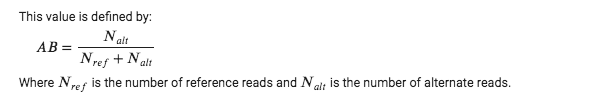


In [ ]:
# call rate before filtering
mt.aggregate_entries(hl.agg.fraction(hl.is_defined(mt.GT)))

The call rate gone up since the initial summary - dropping low-quality samples disproportionately removed missing genotypes.

It’s a good idea to filter out genotypes where the reads aren’t where they should be: if we find a genotype called homozygous reference with >10% alternate reads, a genotype called homozygous alternate with >10% reference reads, or a genotype called heterozygote without a ref / alt balance near 1:1, it is likely to be an error.

In [ ]:
ab = mt.AD[1] / hl.sum(mt.AD)

filter_condition_ab = (
    hl.case()
    .when(mt.GT.is_hom_ref(), ab <= 0.1)
    .when(mt.GT.is_het(), (ab >= 0.25) & (ab <= 0.75))
    .default(ab >= 0.9) # hom-var
)

mt = mt.filter_entries(filter_condition_ab)

In [ ]:
# call rate after filtering
mt.aggregate_entries(hl.agg.fraction(hl.is_defined(mt.GT)))

## Variant QC

Hail has the function [hl.variant_qc](https://hail.is/docs/0.2/methods/genetics.html#hail.methods.variant_qc) to compute a list of useful statistics about **variants** from sequencing data.

Once again, **Click the link** above to see the documentation!

In [ ]:
mt = hl.variant_qc(mt)

In [ ]:
mt.variant_qc.describe()

In [ ]:
mt.variant_qc.AF.show()

### Remove rare sites:

In [ ]:
mt = mt.filter_rows(hl.min(mt.variant_qc.AF) > 1e-6)

In [ ]:
mt.count()

### Remove sites far from [Hardy-Weinberg equilbrium](https://en.wikipedia.org/wiki/Hardy%E2%80%93Weinberg_principle):

In [ ]:
mt = mt.filter_rows(mt.variant_qc.p_value_hwe > 0.005)

In [ ]:
# final variant and sample count
mt.count()

These filters removed about 50% of sites (we started with a bit over 10,000). This is NOT representative of most sequencing datasets! We have already downsampled the full thousand genomes dataset to include more common variants than we’d expect by chance.



# GWAS!

A GWAS is an independent association test performed per variant of a genetic dataset. We use the same phenotype and covariates, but test the genotypes for each variant separately. 

In Hail, the method we use is [hl.linear_regression_rows](https://hail.is/docs/0.2/methods/stats.html#hail.methods.linear_regression_rows).

We use the phenotype `CaffeineConsumption` as our dependent variable, the number of alternate alleles as our independent variable, and no covariates besides an intercept term (that's the `1.0`).

In [ ]:
gwas = hl.linear_regression_rows(y=mt.pheno.CaffeineConsumption, 
                                 x=mt.GT.n_alt_alleles(), 
                                 covariates=[1.0])
gwas.row.describe()

In [ ]:
mt.describe()

Looking at the bottom of the above printout, you can see the linear regression adds new row fields for the beta, standard error, t-statistic, and p-value.

Two of the plots that analysts generally produce are a [Manhattan plot](https://en.wikipedia.org/wiki/Manhattan_plot) and a [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot).

We'll start with the Manhattan plot. The red dashed line indicates a pvalue < 1e-6

In [ ]:
p = hl.plot.manhattan(gwas.p_value)
#p.ray(x=[0], y=[6], length=0, angle=0, line_width=2, line_color ="red", line_dash ="dashed")
show(p)

In [ ]:
p = hl.plot.qq(gwas.p_value)
show(p)

## Confounded!

The Q-Q plot indicates **extreme** inflation of p-values.

The observed p-values drift away from the expectation immediately. Either every SNP in our dataset is causally linked to caffeine consumption (unlikely), or there’s a confounder.

If you've done a GWAS before, you've probably included a few other covariates -- age, sex, and principal components.

```
We didn’t tell you, but sample ancestry was actually used to simulate this phenotype. This leads to a stratified distribution of the phenotype. The solution is to include ancestry as a covariate in our regression.

The linear_regression_rows function can also take column fields to use as covariates. We already annotated our samples with reported ancestry, but it is good to be skeptical of these labels due to human error. Genomes don’t have that problem! Instead of using reported ancestry, we will use genetic ancestry by including computed principal components in our model.

The pca function produces eigenvalues as a list and sample PCs as a Table, and can also produce variant loadings when asked. The hwe_normalized_pca function does the same, using HWE-normalized genotypes for the PCA.
```

Principal components are a measure of genetic ancestry, and can be used to control for [population stratification](https://en.wikipedia.org/wiki/Population_stratification).

We can compute principal components with Hail:

In [ ]:
pca_eigenvalues, pca_scores, pca_loadings = hl.hwe_normalized_pca(mt.GT, compute_loadings=True)

The **eigenvalues** reflect the amount of variance explained by each principal component:

In [ ]:
pca_eigenvalues

The **scores** are the principal components themselves, computed per sample.

In [ ]:
pca_scores.describe()

In [ ]:
pca_scores.scores[0].show()

The **loadings** are the contributions to each component for each variant.

In [ ]:
pca_loadings.describe()

We can **annotate** the principal components back onto `mt`:

In [ ]:
mt = mt.annotate_cols(pca = pca_scores[mt.s])

## Principal components measure ancestry

Now that we’ve got principal components per sample, we may as well plot them! Human history exerts a strong effect in genetic datasets. Even with a 50MB sequencing dataset, we can recover the major human populations.

In [ ]:
p = hl.plot.scatter(mt.pca.scores[0], 
                    mt.pca.scores[1],
                    label=mt.pheno.SuperPopulation,
                    title='PCA', xlabel='PC1', ylabel='PC2')
show(p)

### <font color="brightred"><strong>Question: </strong></font> Does your plot match this one?

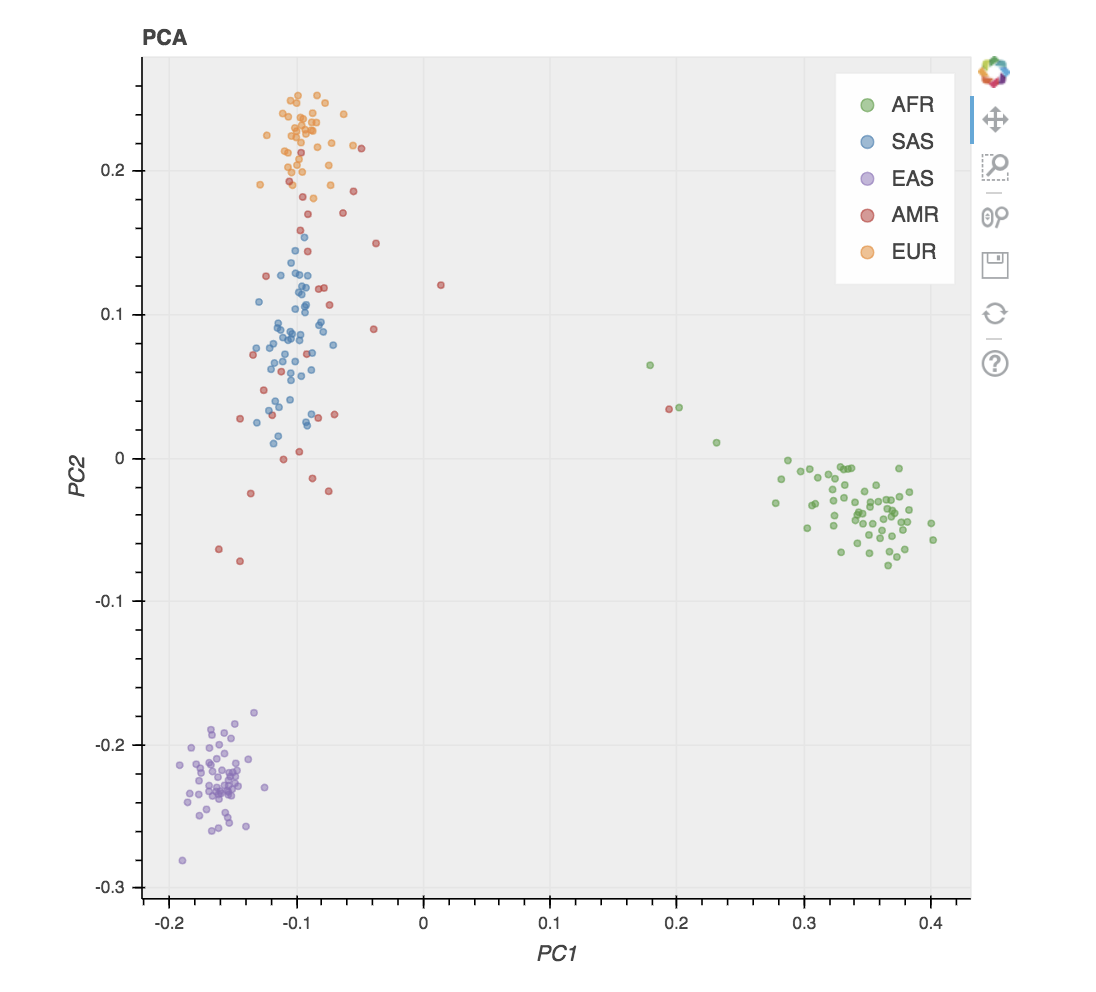

If not, how is it different?


PCA plots are relative measures of distance.  You may find that your plot is rotated, or that the color assignments differ from this plot.  However, each point will retain its relative distance to every other point.

## Control confounders and run another GWAS

Now we can rerun our linear regression, controlling for sample sex and the first few principal components. We’ll do this with input variable the number of alternate alleles as before, and again with input variable the genotype dosage derived from the PL field.

In [ ]:
gwas = hl.linear_regression_rows(
    y=mt.pheno.CaffeineConsumption, 
    x=mt.GT.n_alt_alleles(),
    covariates=[1.0, mt.pheno.isFemale, mt.pca.scores[0], mt.pca.scores[1], mt.pca.scores[2]])

We’ll first make a Q-Q plot to assess inflation…

In [ ]:
p = hl.plot.qq(gwas.p_value)
show(p)

That’s more like it! This shape is indicative of a well-controlled (but not especially well-powered) study. And now for the Manhattan plot:

In [ ]:
p = hl.plot.manhattan(gwas.p_value)
#p.ray(x=[0], y=[6], length=0, angle=0, line_width=2, line_color ="red", line_dash ="dashed")
show(p)

We have found a caffeine consumption locus! Now simply apply Hail’s Nature paper function to publish the result.

We can use a plot command in Hail to allow our point to print out the locus and p-value when we hover over it.

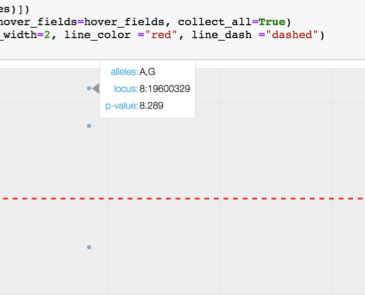

In [ ]:
hover_fields = dict([('alleles', gwas.alleles)])
p = hl.plot.manhattan(gwas.p_value, hover_fields=hover_fields, collect_all=True)
#p.ray(x=[0], y=[6], length=0, angle=0, line_width=2, line_color ="red", line_dash ="dashed")
show(p)

# Burden Tests

GWAS is a great tool for finding associations between **common variants** and disease, but a GWAS can't hope to find associations between rare variants and disease. Even if we have sequencing data for 1,000,000 people, we won't have the statistical power to link a mutation found in only a few people to any disease.

But rare variation has lots of information - especially because statistical genetic theory dictates that rarer variants have, on average, stronger effects on disease per allele.

One possible strategy is to **group together rare variants with similar predicted consequence**. For example, we can group all variants that are predicted to knock out the function of each gene and test the variants for each gene as a group.

We will be running a burden test on our common variant dataset to demonstrate the technical side, but we shouldn't hope to find anything here -- especially because we've only got 10,000 variants!



## Import gene data

We start by importing gene names and coordinates.

In [ ]:
gene_ht = hl.import_table(bucket + '/data/ensembl_gene_annotations.txt', impute=True)

In [ ]:
gene_ht.show()

In [ ]:
gene_ht.count()

## Create an interval key

In [ ]:
gene_ht = gene_ht.transmute(interval = hl.locus_interval(gene_ht['Chromosome'],
                                                         gene_ht['Gene start'],
                                                         gene_ht['Gene end'], 
                                                         reference_genome='GRCh37'))
gene_ht = gene_ht.key_by('interval')

In [ ]:
gene_ht.describe()

## Annotate variants using these intervals

In [ ]:
mt = mt.annotate_rows(gene_info = gene_ht[mt.locus])

In [ ]:
mt.gene_info.show()

In [ ]:
mt.describe()

## Aggregate genotypes per gene

There is no `hl.burden_test` function -- instead, a burden test is the composition of two modular pieces of Hail functionality:

 - `group_rows_by / aggregate`
 - `hl.linear_regression`
 
While this might be a few more lines of code to write than `hl.burden_test`, it means that you can flexibly specify the genotype aggregation however you like. Using other tools , you may have a few ways to aggregate, but if you want to do something different you are out of luck!

In [ ]:
burden_mt = (
    mt
    .group_rows_by(gene = mt.gene_info['Gene name'])
    .aggregate(n_variants = hl.agg.count_where(mt.GT.n_alt_alleles() > 0))
)

## What is `burden_mt`?

It is a **gene-by-sample** matrix (compare to `mt`, a **variant-by-sample** matrix).

It has one row field, the `gene`.

It has one entry field, `n_variants`.

It has all the column fields from `mt`.

In [ ]:
burden_mt.describe()

## Run linear regression per gene

This should look familiar!

In [ ]:
burden_results = hl.linear_regression_rows(
    y=burden_mt.pheno.CaffeineConsumption, 
    x=burden_mt.n_variants,
    covariates=[1.0, 
                burden_mt.pheno.isFemale, 
                burden_mt.pca.scores[0], 
                burden_mt.pca.scores[1], 
                burden_mt.pca.scores[2]])

## Sorry, no `hl.plot.manhattan` for genes!

Instead, we can sort by p-value and print:  --- I am waiting for some code for sorting: AR

In [ ]:
burden_results.describe()

In [ ]:
burden_results.show()

In [ ]:
burden_results_pd = burden_results.to_pandas()
burden_results_pd.sort_values(by=['p_value']).head(10)

## <font color="brightred"><strong>Exercise: </strong></font> Where along the genome can we find the top gene?

# Rare variant analysis

Here we’ll demonstrate how one can use the expression language to group and count by any arbitrary properties in row and column fields. Hail also implements the sequence kernel association test (SKAT).

In [ ]:
entries = mt.entries()
results = (entries.group_by(pop = entries.pheno.SuperPopulation, chromosome = entries.locus.contig)
      .aggregate(n_het = hl.agg.count_where(entries.GT.is_het())))

In [ ]:
results.show()


What if we want to group by minor allele frequency bin and hair color, and calculate the mean GQ?

In [ ]:
entries = entries.annotate(maf_bin = hl.cond(entries.info.AF[0]<0.01, "< 1%",
                             hl.cond(entries.info.AF[0]<0.05, "1%-5%", ">5%")))

results2 = (entries.group_by(af_bin = entries.maf_bin, purple_hair = entries.pheno.PurpleHair)
      .aggregate(mean_gq = hl.agg.stats(entries.GQ).mean,
                 mean_dp = hl.agg.stats(entries.DP).mean))

In [ ]:
results2.show()

We’ve shown that it’s easy to aggregate by a couple of arbitrary statistics. This specific examples may not provide especially useful pieces of information, but this same pattern can be used to detect effects of rare variation:

* Count the number of heterozygous genotypes per gene by functional category (synonymous, missense, or loss-of-function) to estimate per-gene functional constraint

* Count the number of singleton loss-of-function mutations per gene in cases and controls to detect genes involved in disease

# Whirlwind tour

You've seen just a very small fraction of the functionality in Hail. Here are a few examples of things that a large library makes easy.

**The case for modularity**

Most of the "black-box" methods we've used above (`impute_sex`, `variant_qc`, `sample_qc`, etc) are actually implemented on top of Hail's Python interface using `Table` and `MatrixTable` operations, expressions, aggregations, and linear algebra!

## Find related individuals using IBD (identity by descent)

In [ ]:
ht = hl.identity_by_descent(mt).cache()

ht.describe()

In [ ]:
ht.filter(ht.ibd.PI_HAT > 0.20).show()

## Infer sex from X-chromosome data

In [ ]:
ht = hl.impute_sex(mt.GT).cache()

In [ ]:
ht.show()

## Simulate genetic data

In [ ]:
sim_mt = hl.balding_nichols_model(n_populations=3,
                                  n_samples=1000, 
                                  n_variants=1000)

# simulate variant effects using spike-and-slab model
spike_prob = 0.2
sim_mt = sim_mt.annotate_rows(beta = hl.rand_bool(spike_prob) * hl.rand_norm(0, 1))

# compute risk scores from betas
sim_mt = sim_mt.annotate_cols(risk = hl.agg.sum(sim_mt.beta * sim_mt.GT.n_alt_alleles()) / sim_mt.count_rows())

In [ ]:
show(hl.plot.histogram(sim_mt.risk))

# Congrats! 

If you’ve made it this far, you’re perfectly primed to read the Overview, look through the Hail objects representing many core concepts in genetics, and check out the many Hail functions defined in the Python API. If you use Hail for your own science, we’d love to hear from you on Gitter chat or the discussion forum.

There’s also a lot of functionality inside Hail that we didn’t get to in this broad overview. 

Things like:

* Flexible import and export to a variety of data and annotation formats (VCF, BGEN, PLINK, JSON, TSV, …)
* Simulation
* Burden tests
* Kinship and pruning (IBD, GRM, RRM)
* Family-based tests and utilities
* Distributed file system utilities
* Interoperability with Python and Spark machine learning libraries
* More!


For reference, here’s the full workflow to all tutorial endpoints combined into one cell. It may take a minute! It’s doing a lot of work.

```
table = hl.import_table(bucket + 'data/1kg_annotations.txt', impute=True).key_by('Sample')

mt = hl.read_matrix_table(bucket + 'data/1kg.mt')
mt = mt.annotate_cols(pheno = table[mt.s])
mt = hl.sample_qc(mt)
mt = mt.filter_cols((mt.sample_qc.dp_stats.mean >= 4) & (mt.sample_qc.call_rate >= 0.97))
ab = mt.AD[1] / hl.sum(mt.AD)
filter_condition_ab = ((mt.GT.is_hom_ref() & (ab <= 0.1)) |
                        (mt.GT.is_het() & (ab >= 0.25) & (ab <= 0.75)) |
                        (mt.GT.is_hom_var() & (ab >= 0.9)))
mt = mt.filter_entries(filter_condition_ab)
mt = hl.variant_qc(mt)
mt = mt.filter_rows(mt.variant_qc.AF[1] > 0.01)

eigenvalues, pcs, _ = hl.hwe_normalized_pca(mt.GT)

mt = mt.annotate_cols(scores = pcs[mt.s].scores)
gwas = hl.linear_regression_rows(
    y=mt.pheno.CaffeineConsumption,
    x=mt.GT.n_alt_alleles(),
    covariates=[1.0, mt.pheno.isFemale, mt.scores[0], mt.scores[1], mt.scores[2]])

        
```




In [ ]:
table = hl.import_table(bucket + '/data/1kg_annotations.txt', impute=True).key_by('Sample')

mt = hl.read_matrix_table(bucket + '/data/1kg.mt')
mt = mt.annotate_cols(pheno = table[mt.s])
mt = hl.sample_qc(mt)
mt = mt.filter_cols((mt.sample_qc.dp_stats.mean >= 4) & (mt.sample_qc.call_rate >= 0.97))
ab = mt.AD[1] / hl.sum(mt.AD)
filter_condition_ab = ((mt.GT.is_hom_ref() & (ab <= 0.1)) |
                        (mt.GT.is_het() & (ab >= 0.25) & (ab <= 0.75)) |
                        (mt.GT.is_hom_var() & (ab >= 0.9)))
mt = mt.filter_entries(filter_condition_ab)
mt = hl.variant_qc(mt)
mt = mt.filter_rows(mt.variant_qc.AF[1] > 0.01)

eigenvalues, pcs, _ = hl.hwe_normalized_pca(mt.GT)

mt = mt.annotate_cols(scores = pcs[mt.s].scores)
gwas = hl.linear_regression_rows(
    y=mt.pheno.CaffeineConsumption,
    x=mt.GT.n_alt_alleles(),
    covariates=[1.0, mt.pheno.isFemale, mt.scores[0], mt.scores[1], mt.scores[2]])

In [ ]:
p = hl.plot.manhattan(gwas.p_value)
p.ray(x=[0], y=[6], length=0, angle=0, line_width=2, line_color ="red", line_dash ="dashed")
show(p)

## Output from this notebook

[Can be found here](https://storage.googleapis.com/terra-featured-workspaces/hail-tutorials/Load_Data_From_BiqQuery/2_Hail_GWAS_Tutorial.html)